# Real State Investment - Roofstock Analysis

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium
from geopy.geocoders import Nominatim
import folium
import geocoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_rooftop_main.csv',index_col=0)

In [3]:
df.head()

Street         City State    Zip      Rooms sqft area  Built in  \
0      1144 Soria St  Saint Louis    MO  63138  3bd, 1ba       720       1966   
1           2 Ivy Dr  Little Rock    AR  72209  3bd, 1ba     1,733       1955   
2    190 Grenoble Ln   Florissant    MO  63033  3bd, 1ba       888       1957   
3  6611 Diamond Pass  San Antonio    TX  78239  3bd, 3ba     1,879       1998   
4   9934 PERMIAN BAY  San Antonio    TX  78245  3bd, 3ba     1,582       2000   

      Price Current Rents Cap Rate Gross Yield  Rating  \
0   $80,000          $750    11.3%      $4,814       2   
1  $115,000          $800     8.3%      $5,091       2   
2  $105,000        $1,050    12.0%      $6,913       3   
3  $195,000        $1,450     8.9%      $7,531       3   
4  $180,000        $1,400     9.3%      $7,423       3   

                                               Links  
0  https://www.roofstock.com/investment-property-...  
1  https://www.roofstock.com/investment-property-...  
2  https://www.roofstock.com/investment-property-...  
3  https://www.roofstock.com/investment-property-...  
4  https://www.roofstock.com/investment-property-...

In [4]:
df.shape

(620, 13)

# Part 1- Clustering Properties by best Cap Rate and Prices

## Data Cleaning 

Let's split the column rooms into bedrooms and bathrooms

In [5]:
df['bd'] = df['Rooms'].str.extract('([0-9])')
df['ba'] = df['Rooms'].str.extract('([0-9]ba)')
df['ba'] = df['ba'].str.extract('([0-9])')

In [6]:
df['ba'] = [int(x) for x in df['ba'].values]
df['bd'] = [int(x) for x in df['bd'].values]

In [7]:
len(df['bd']),len(df['ba'])

(620, 620)

In [8]:
df.head()

Street         City State    Zip      Rooms sqft area  Built in  \
0      1144 Soria St  Saint Louis    MO  63138  3bd, 1ba       720       1966   
1           2 Ivy Dr  Little Rock    AR  72209  3bd, 1ba     1,733       1955   
2    190 Grenoble Ln   Florissant    MO  63033  3bd, 1ba       888       1957   
3  6611 Diamond Pass  San Antonio    TX  78239  3bd, 3ba     1,879       1998   
4   9934 PERMIAN BAY  San Antonio    TX  78245  3bd, 3ba     1,582       2000   

      Price Current Rents Cap Rate Gross Yield  Rating  \
0   $80,000          $750    11.3%      $4,814       2   
1  $115,000          $800     8.3%      $5,091       2   
2  $105,000        $1,050    12.0%      $6,913       3   
3  $195,000        $1,450     8.9%      $7,531       3   
4  $180,000        $1,400     9.3%      $7,423       3   

                                               Links  bd  ba  
0  https://www.roofstock.com/investment-property-...   3   1  
1  https://www.roofstock.com/investment-property-...   3   1  
2  https://www.roofstock.com/investment-property-...   3   1  
3  https://www.roofstock.com/investment-property-...   3   3  
4  https://www.roofstock.com/investment-property-...   3   3

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 0 to 619
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Street         616 non-null    object
 1   City           620 non-null    object
 2   State          620 non-null    object
 3   Zip            620 non-null    int64 
 4   Rooms          620 non-null    object
 5   sqft area      620 non-null    object
 6   Built in       620 non-null    int64 
 7   Price          620 non-null    object
 8   Current Rents  620 non-null    object
 9   Cap Rate       620 non-null    object
 10  Gross Yield    620 non-null    object
 11  Rating         620 non-null    int64 
 12  Links          620 non-null    object
 13  bd             620 non-null    int64 
 14  ba             620 non-null    int64 
dtypes: int64(5), object(10)
memory usage: 77.5+ KB


In [10]:
df['Price'] = df['Price'].str.extract('\$([0-9.,]+)')
df['Current Rents'] = df['Current Rents'].str.extract('\$([0-9.,]+)')
df['Gross Yield'] = df['Gross Yield'].str.extract('\$([0-9.,]+)')
df.replace(',','', regex=True, inplace=True)

In [11]:
df['Cap Rate'] = list(map(lambda x: x[:-1], df['Cap Rate'].values))
df['Cap Rate'] = [float(x) for x in df['Cap Rate'].values]

In [12]:
df.head()

Street         City State    Zip     Rooms sqft area  Built in  \
0      1144 Soria St  Saint Louis    MO  63138  3bd 1ba       720       1966   
1           2 Ivy Dr  Little Rock    AR  72209  3bd 1ba      1733       1955   
2    190 Grenoble Ln   Florissant    MO  63033  3bd 1ba       888       1957   
3  6611 Diamond Pass  San Antonio    TX  78239  3bd 3ba      1879       1998   
4   9934 PERMIAN BAY  San Antonio    TX  78245  3bd 3ba      1582       2000   

    Price Current Rents  Cap Rate Gross Yield  Rating  \
0   80000           750      11.3        4814       2   
1  115000           800       8.3        5091       2   
2  105000          1050      12.0        6913       3   
3  195000          1450       8.9        7531       3   
4  180000          1400       9.3        7423       3   

                                               Links  bd  ba  
0  https://www.roofstock.com/investment-property-...   3   1  
1  https://www.roofstock.com/investment-property-...   3   1  
2  https://www.roofstock.com/investment-property-...   3   1  
3  https://www.roofstock.com/investment-property-...   3   3  
4  https://www.roofstock.com/investment-property-...   3   3

In [13]:
df['Current Rents']=df['Current Rents'].astype('int64')
df['sqft area']=df['sqft area'].astype('int64')
df['Built in']=df['Built in'].astype('int64')
df['Price']=df['Price'].astype('int64')
df['Current Rents']=df['Current Rents'].astype('int64')
df['Gross Yield']=df['Gross Yield'].astype('int64')

In [14]:
df.drop(columns=['Rooms','Links'],axis=1,inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 0 to 619
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Street         616 non-null    object 
 1   City           620 non-null    object 
 2   State          620 non-null    object 
 3   Zip            620 non-null    int64  
 4   sqft area      620 non-null    int64  
 5   Built in       620 non-null    int64  
 6   Price          620 non-null    int64  
 7   Current Rents  620 non-null    int64  
 8   Cap Rate       620 non-null    float64
 9   Gross Yield    620 non-null    int64  
 10  Rating         620 non-null    int64  
 11  bd             620 non-null    int64  
 12  ba             620 non-null    int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 67.8+ KB


In [16]:
df.rename(columns={'Gross Yield':'Cash flow'},inplace=True)
df.head()

Street         City State    Zip  sqft area  Built in   Price  \
0      1144 Soria St  Saint Louis    MO  63138        720      1966   80000   
1           2 Ivy Dr  Little Rock    AR  72209       1733      1955  115000   
2    190 Grenoble Ln   Florissant    MO  63033        888      1957  105000   
3  6611 Diamond Pass  San Antonio    TX  78239       1879      1998  195000   
4   9934 PERMIAN BAY  San Antonio    TX  78245       1582      2000  180000   

   Current Rents  Cap Rate  Cash flow  Rating  bd  ba  
0            750      11.3       4814       2   3   1  
1            800       8.3       5091       2   3   1  
2           1050      12.0       6913       3   3   1  
3           1450       8.9       7531       3   3   3  
4           1400       9.3       7423       3   3   3

In [17]:
df['State'].value_counts()

IL    87
AL    58
SC    51
TX    49
IN    47
OH    47
MO    44
GA    41
OK    30
NJ    29
TN    25
MI    22
MS    20
AR    16
IA     9
PA     9
NC     9
FL     9
DE     6
WI     6
CA     3
KS     1
NV     1
NY     1
Name: State, dtype: int64

In [18]:
States = df[['State','sqft area','Built in','Price','Current Rents','Cap Rate','Rating']].groupby(['State']).mean()

In [19]:
States.sort_values(by='Price', ascending=False)

sqft area     Built in          Price  Current Rents   Cap Rate  \
State                                                                      
NV     1737.000000  2018.000000  335000.000000    1750.000000   6.300000   
CA     1606.666667  1975.333333  308333.333333    1740.000000   7.233333   
TX     1981.061224  1995.367347  271857.183673    1910.061224   8.761224   
NJ     1338.413793  1959.827586  213806.896552    1706.620690  10.055172   
PA     1613.555556  1948.333333  203477.777778    1584.444444  11.455556   
DE     1153.666667  1937.333333  183333.333333    1411.833333   9.416667   
GA     1627.512195  1987.926829  182732.000000    1326.975610   9.351220   
SC     1502.411765  1989.196078  155381.980392    1250.098039  10.090196   
NY     2956.000000  1900.000000  155000.000000    1950.000000  15.100000   
MS     1608.350000  1987.850000  153595.000000    1326.500000  10.585000   
FL     1394.222222  1982.888889  151922.222222    1203.333333   9.711111   
IN     1556.978723  1962.234043  144565.148936    1216.106383  11.214894   
OK     1589.866667  1973.600000  142859.666667    1141.366667  10.893333   
IL     1382.022989  1948.954023  142279.310345    1445.666667  12.858621   
NC     1463.000000  1989.222222  139425.777778    1083.888889   9.566667   
TN     1635.040000  1975.520000  137212.000000    1199.560000  10.996000   
WI     1894.500000  1927.166667  134000.000000    1543.166667  13.883333   
AL     1399.206897  1971.844828  125133.620690    1102.206897  11.341379   
OH     1524.106383  1942.595745  124187.234043    1112.617021  11.463830   
MI     1073.181818  1952.454545  118047.727273    1181.727273  14.309091   
IA     1042.000000  1934.666667  113433.333333    1031.111111  11.088889   
MO     1164.886364  1949.136364  109922.727273    1072.000000  12.659091   
KS      918.000000  1935.000000  103500.000000    1100.000000  12.800000   
AR     1296.875000  1963.187500   95331.250000     873.375000  11.168750   

         Rating  
State            
NV     3.000000  
CA     2.666667  
TX     3.183673  
NJ     3.137931  
PA     2.444444  
DE     2.333333  
GA     2.951220  
SC     3.549020  
NY     1.000000  
MS     3.700000  
FL     1.777778  
IN     2.744681  
OK     2.933333  
IL     2.321839  
NC     2.666667  
TN     2.400000  
WI     1.666667  
AL     2.689655  
OH     2.574468  
MI     1.818182  
IA     2.444444  
MO     2.181818  
KS     2.000000  
AR     2.000000

## Longitude and Latitude

In [ ]:
df.Street.fillna('')

In [ ]:
address_list=[]
Latitude=[]
Longitude = []
x=0
for i, row in df.iterrows():
    address = str(df.Street[i])+', '+str(df.City[i])+', '+str(df.State[i])+' '+str(df.Zip[i])+', USA'
    #print(address)
    address_list.append(address)
    geolocator = Nominatim(user_agent="Pan_explorer")
    location = geolocator.geocode(address)
    while x==0:
        location = geolocator.geocode(address)
        try:
            latitude = location.latitude
            x=1
        except AttributeError:
            x=0
            address=(address.split(" ", 1))[1]
            #Latitude.append('')
            #Longitude.append('')
            pass
    Latitude.append(latitude)
    longitude = location.longitude
    Longitude.append(longitude)
    x=0

In [ ]:
address_df= pd.DataFrame(list(zip(address_list,Latitude,Longitude,list(df.Street))),columns=['Address','Latitude','Longitude','Street'])

address_df

In [ ]:
add2= address_df[address_df['Latitude']=='']
add2

In [20]:
#address_df.to_csv('Location_roofstock.csv')

## DBSCAN

In [21]:
address = 'USA'

geolocator = Nominatim(user_agent="Pan_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of USA are 39.7837304, -100.4458825.


In [22]:
ad = pd.read_csv('Location_roofstock.csv',index_col=False)
ad.drop('Unnamed: 0',axis=1,inplace=True)

In [23]:
map_usa = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, label in zip(ad['Latitude'], ad['Longitude'], ad['Street']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
map_usa

In [24]:
ad['Price']=df['Price']
ad['Cap Rate']= df['Cap Rate']

In [25]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = ad[['Latitude','Longitude','Cap Rate']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
ad["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

ad[["Address","Cap Rate","Clus_Db"]].head(5)

Address  Cap Rate  Clus_Db
0      1144 Soria St, Saint Louis, MO 63138, USA      11.3        0
1           2 Ivy Dr, Little Rock, AR 72209, USA       8.3       -1
2     190 Grenoble Ln, Florissant, MO 63033, USA      12.0        0
3  6611 Diamond Pass, San Antonio, TX 78239, USA       8.9        1
4   9934 PERMIAN BAY, San Antonio, TX 78245, USA       9.3        1

In [26]:
map_usa = folium.Map(location=[latitude, longitude], zoom_start=4.2)
from folium import IFrame
from folium.features import DivIcon
from pylab import *

cmap = cm.get_cmap('jet', 8)    
colors=[]
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    color = matplotlib.colors.rgb2hex(rgba)
    colors.append(color)

# add markers to map
for clust_number in set(labels):
    c=(('#FFFFFF') if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = ad[ad.Clus_Db == clust_number]
    for lat, lng, label in zip(clust_set['Latitude'], clust_set['Longitude'], clust_set['Street']):
        label = folium.Popup(label, parse_html=True)
        
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=c,
            fill=True,
            fill_color=c,
            fill_opacity=0.7,
            parse_html=False).add_to(map_usa)
        
    if clust_number != -1:
        cenx=np.mean(clust_set.Latitude) 
        ceny=np.mean(clust_set.Longitude) 
        
        
        p=[cenx,ceny]
        html='<div style="font-size: 18pt; color : black">'+str(clust_number)+'</div>'
        folium.Marker(p, icon=DivIcon(
                        icon_size=(150,36),
                        icon_anchor=(7,20),
                        html=html,
                            )).add_to(map_usa)
        map_usa.add_child(folium.CircleMarker(p, radius=15))
        
        #text = str(clust_number)
        #iframe = folium.IFrame(text, width=100, height=100)
        #popup = folium.Popup(iframe, max_width=300)
        #Text = folium.Marker(location=[cenx,ceny], popup=popup,
                     #icon=folium.Icon(icon_color='white'))
        #map_usa.add_child(Text)
        #plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Cap Rate: '+ str(np.mean(clust_set['Cap Rate'])))
    
map_usa

Cluster 0, Avg Cap Rate: 12.686842105263159
Cluster 1, Avg Cap Rate: 8.704545454545453
Cluster 2, Avg Cap Rate: 10.838709677419352
Cluster 3, Avg Cap Rate: 11.882142857142858
Cluster 4, Avg Cap Rate: 9.736496350364964
Cluster 5, Avg Cap Rate: 8.192307692307692
Cluster 6, Avg Cap Rate: 9.710810810810809


In [79]:
map_usa.save('map_usa.html')

# Part 2 - Regression Model for Cap Rate prediction

## Data Cleaning

### Factorize States

In [27]:
statef=df.copy()

In [28]:
columnsf=statef[['State']]

In [29]:
for i in columnsf.columns:
    statef[i] = pd.factorize(statef[i])[0]

In [30]:
statef=statef[['State']]

In [31]:
#statef.to_csv('StatesFactorize.csv')

### Highlights Data of the Houses

Load the highlights of each home

In [32]:
highlights = pd.read_csv('highlights_rooftop.csv')

In [33]:
highlights.head()

Roof       Attic      Bathrooms       Basement        HVAC  \
0          --          --             --             --          --   
1          --          --             --             --          --   
2  Functional  Functional  Needs Repairs  Needs Repairs  Functional   
3          --          --             --             --          --   
4          --          --             --             --          --   

     Bedrooms  Electrical    Exterior      Garage    Plumbing    Landscaping  \
0          --          --          --          --          --             --   
1          --          --          --          --          --             --   
2  Functional  Functional  Functional  Functional  Functional  Needs Repairs   
3          --          --          --          --          --             --   
4          --          --          --          --          --             --   

   Structural     Kitchen  
0          --          --  
1          --          --  
2  Functional  Functional  
3          --          --  
4          --          --

In [34]:
highlights.nunique(dropna=False)

Roof           3
Attic          4
Bathrooms      4
Basement       4
HVAC           3
Bedrooms       3
Electrical     3
Exterior       4
Garage         4
Plumbing       3
Landscaping    3
Structural     3
Kitchen        3
dtype: int64

In [35]:
mapper = {'--':int(0),'Functional':int(2),'Needs Repairs':(1)}

In [36]:
for i in list(highlights.columns):
    highlights[i].replace(mapper, inplace=True)
    highlights[i] = highlights[i].replace(np.nan,0)

In [37]:
highlights.isnull().sum().sum()

0

In [38]:
highlights=highlights.astype(int)

In [39]:
highlights['Attic'].value_counts()

0    373
2    224
1     23
Name: Attic, dtype: int64

In [40]:
highlights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Roof         620 non-null    int32
 1   Attic        620 non-null    int32
 2   Bathrooms    620 non-null    int32
 3   Basement     620 non-null    int32
 4   HVAC         620 non-null    int32
 5   Bedrooms     620 non-null    int32
 6   Electrical   620 non-null    int32
 7   Exterior     620 non-null    int32
 8   Garage       620 non-null    int32
 9   Plumbing     620 non-null    int32
 10  Landscaping  620 non-null    int32
 11  Structural   620 non-null    int32
 12  Kitchen      620 non-null    int32
dtypes: int32(13)
memory usage: 31.6 KB


In [41]:
highlights.head()

Roof  Attic  Bathrooms  Basement  HVAC  Bedrooms  Electrical  Exterior  \
0     0      0          0         0     0         0           0         0   
1     0      0          0         0     0         0           0         0   
2     2      2          1         1     2         2           2         2   
3     0      0          0         0     0         0           0         0   
4     0      0          0         0     0         0           0         0   

   Garage  Plumbing  Landscaping  Structural  Kitchen  
0       0         0            0           0        0  
1       0         0            0           0        0  
2       2         2            1           2        2  
3       0         0            0           0        0  
4       0         0            0           0        0

### Concatenating all the parameters

In [42]:
df['N_State']=statef['State']

In [43]:
data_result = pd.concat([df, highlights], axis=1)

In [44]:
data_result.head()

Street         City State    Zip  sqft area  Built in   Price  \
0      1144 Soria St  Saint Louis    MO  63138        720      1966   80000   
1           2 Ivy Dr  Little Rock    AR  72209       1733      1955  115000   
2    190 Grenoble Ln   Florissant    MO  63033        888      1957  105000   
3  6611 Diamond Pass  San Antonio    TX  78239       1879      1998  195000   
4   9934 PERMIAN BAY  San Antonio    TX  78245       1582      2000  180000   

   Current Rents  Cap Rate  Cash flow  ...  Basement  HVAC  Bedrooms  \
0            750      11.3       4814  ...         0     0         0   
1            800       8.3       5091  ...         0     0         0   
2           1050      12.0       6913  ...         1     2         2   
3           1450       8.9       7531  ...         0     0         0   
4           1400       9.3       7423  ...         0     0         0   

   Electrical  Exterior  Garage  Plumbing  Landscaping  Structural  Kitchen  
0           0         0       0         0            0           0        0  
1           0         0       0         0            0           0        0  
2           2         2       2         2            1           2        2  
3           0         0       0         0            0           0        0  
4           0         0       0         0            0           0        0  

[5 rows x 27 columns]

<AxesSubplot:>

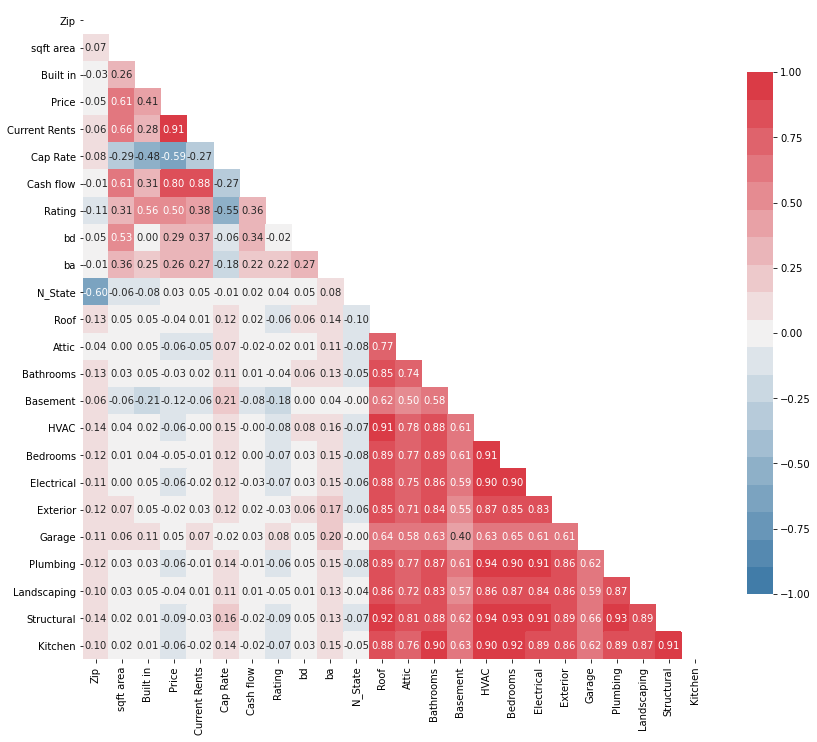

In [45]:
corr=data_result.corr()
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask = mask, annot = True, fmt = ".2f", cmap = sns.diverging_palette(240, 10, n=19),
           vmin = -1, vmax = 1, cbar_kws = {"shrink": .8})

<AxesSubplot:xlabel='State', ylabel='Price'>

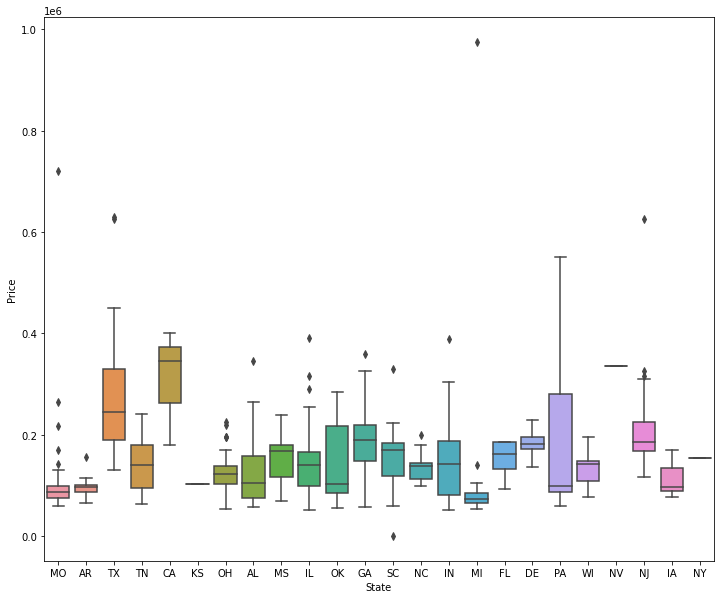

In [46]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(x="State", y="Price", data=data_result)

In [47]:
data = data_result.copy()
dummies = pd.get_dummies(data.City)
dummies1 = pd.get_dummies(data.Zip,prefix='p')
dummies2 = pd.get_dummies(data.State)
data = pd.concat([data,dummies,dummies1,dummies2],axis = 1)

In [48]:
data.drop(['State','City','Street','N_State'],axis=1,inplace=True)

In [49]:
data['sqft area per room'] = data['sqft area']/data['bd']

In [50]:
del data['sqft area']
del data['bd']

In [51]:
data.drop(data.index[data['Current Rents'] == 0], inplace = True)

In [52]:
data.drop(data.index[data['Price'] == 0], inplace = True)

In [53]:
data.head()

Zip  Built in   Price  Current Rents  Cap Rate  Cash flow  Rating  ba  \
0  63138      1966   80000            750      11.3       4814       2   1   
1  72209      1955  115000            800       8.3       5091       2   1   
2  63033      1957  105000           1050      12.0       6913       3   1   
3  78239      1998  195000           1450       8.9       7531       3   3   
4  78245      2000  180000           1400       9.3       7423       3   3   

   Roof  Attic  ...  NV  NY  OH  OK  PA  SC  TN  TX  WI  sqft area per room  
0     0      0  ...   0   0   0   0   0   0   0   0   0          240.000000  
1     0      0  ...   0   0   0   0   0   0   0   0   0          577.666667  
2     2      2  ...   0   0   0   0   0   0   0   0   0          296.000000  
3     0      0  ...   0   0   0   0   0   0   0   1   0          626.333333  
4     0      0  ...   0   0   0   0   0   0   0   1   0          527.333333  

[5 rows x 662 columns]

## Random Forest Regressor

In [54]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [55]:
features = data.drop(['Cap Rate','Cash flow','Current Rents'],axis=1)
feature_list = list(features.columns)
features = np.array(features)

target = np.array(data['Cap Rate'])

In [56]:
def Model(features,target):
    kf = KFold(n_splits=6,random_state=2,shuffle=True)
    accuracies = []
    for train_index, test_index in kf.split(features):

        data_train   = features[train_index]
        target_train = target[train_index]

        data_test    = features[test_index]
        target_test  = target[test_index]

        rf = RandomForestRegressor(n_estimators = 1000, 
                                   random_state = 2, 
                                   criterion = 'mse',
                                   bootstrap=True)

        rf.fit(data_train, target_train)

        predictions = rf.predict(data_test)

        errors = abs(predictions - target_test)
        
        #print(target_test)

        print('Mean Absolute Error:', round(np.mean(errors), 2))

        mape = 100 * (errors / target_test)
        accuracy = 100 - np.mean(mape)
        print('Accuracy:', round(accuracy, 2), '%.')

        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    print('Average accuracy:', average_accuracy)

In [57]:
Model(features,target)

Mean Absolute Error: 1.03
Accuracy: 91.11 %.
Mean Absolute Error: 1.04
Accuracy: 91.07 %.
Mean Absolute Error: 1.1
Accuracy: 89.63 %.
Mean Absolute Error: 1.12
Accuracy: 89.84 %.
Mean Absolute Error: 0.88
Accuracy: 91.63 %.
Mean Absolute Error: 1.1
Accuracy: 89.21 %.
Average accuracy: 90.41597677534247


In [58]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [59]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, target)

print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}


In [60]:
rf2 = RandomForestRegressor(n_estimators = 1600, 
                                random_state = 2,
                               max_features ='auto',
                               max_depth = 90,
                                min_samples_split = 5,
                                min_samples_leaf = 1,
                                criterion = 'mse',
                                bootstrap=True)
rf2.fit(features, target)

RandomForestRegressor(max_depth=90, min_samples_split=5, n_estimators=1600,
                      random_state=2)

In [61]:
predictions = rf2.predict(features)

errors = abs(predictions - target)

print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = 100 * (errors / target)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.44
Accuracy: 95.93 %.


## Testing the trained Model

In [62]:
data_result[data_result['Zip']== 77024]

Empty DataFrame
Columns: [Street, City, State, Zip, sqft area, Built in, Price, Current Rents, Cap Rate, Cash flow, Rating, bd, ba, N_State, Roof, Attic, Bathrooms, Basement, HVAC, Bedrooms, Electrical, Exterior, Garage, Plumbing, Landscaping, Structural, Kitchen]
Index: []

[0 rows x 27 columns]

In [63]:
test = pd.DataFrame().reindex_like(data)

In [64]:
test = test.replace(np.nan,0).astype(int)
test.head()

Zip  Built in  Price  Current Rents  Cap Rate  Cash flow  Rating  ba  Roof  \
0    0         0      0              0         0          0       0   0     0   
1    0         0      0              0         0          0       0   0     0   
2    0         0      0              0         0          0       0   0     0   
3    0         0      0              0         0          0       0   0     0   
4    0         0      0              0         0          0       0   0     0   

   Attic  ...  NV  NY  OH  OK  PA  SC  TN  TX  WI  sqft area per room  
0      0  ...   0   0   0   0   0   0   0   0   0                   0  
1      0  ...   0   0   0   0   0   0   0   0   0                   0  
2      0  ...   0   0   0   0   0   0   0   0   0                   0  
3      0  ...   0   0   0   0   0   0   0   0   0                   0  
4      0  ...   0   0   0   0   0   0   0   0   0                   0  

[5 rows x 662 columns]

In [65]:
test=test.iloc[[0]]

In [66]:
list(test.columns)

['Zip',
 'Built in',
 'Price',
 'Current Rents',
 'Cap Rate',
 'Cash flow',
 'Rating',
 'ba',
 'Roof',
 'Attic',
 'Bathrooms',
 'Basement',
 'HVAC',
 'Bedrooms',
 'Electrical',
 'Exterior',
 'Garage',
 'Plumbing',
 'Landscaping',
 'Structural',
 'Kitchen',
 'Abbottstown',
 'Akron',
 'Alabaster',
 'Alpharetta',
 'Ambridge',
 'Anderson',
 'Appleton',
 'Arlington Heights',
 'Atco',
 'Athens',
 'Atlanta',
 'Aurora',
 'Austell',
 'Austin',
 'Barnegat',
 'Barstow',
 'Bartlett',
 'Batesburg-Leesville',
 'Bayville',
 'Beaumont',
 'Bedford',
 'Beecher',
 'Belleville',
 'Belton',
 'Bessemer',
 'Bethalto',
 'Birmingham',
 'Bishopville',
 'Blacklick',
 'Blythewood',
 'Bourbonnais',
 'Bradley',
 'Brandon',
 'Brook Park',
 'Buckner',
 'Cahokia',
 'Calera',
 'Calumet City',
 'Camden',
 'Cameron',
 'Canton',
 'Cayce',
 'Center Point',
 'Chapin',
 'Chicago',
 'Cincinnati',
 'Clarksville',
 'Cleveland',
 'Cleveland Heights',
 'Collinsville',
 'Columbia',
 'Columbus',
 'Conley',
 'Converse',
 'Cordova',


In [67]:
test['Built in']=1991
test['Price']=600000
#test['Current Rents']=0
test['Zip']=77024
test['Rating']=4
test['ba']=3
test['Roof']=2
test['Attic']=2
test['Roof']=2
test['Bathrooms']=2
test['HVAC']=2
test['Bedrooms']=2
test['Electrical']=2
test['Exterior']=2
test['Garage']=2
test['Plumbing']=2
test['Landscaping']=2
test['Structural']=2
test['Kitchen']=2
test['Houston']=1
test['TX']= 1
test['sqft area per room'] =866.67

In [68]:
testx = test.drop(['Cap Rate','Cash flow','Current Rents'],axis=1)
testx =np.array(testx)

In [69]:
rf2.predict(testx)

array([8.37737367])